In [1]:
# libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import seaborn as sns

from tqdm import tqdm
import random

# Objective
The goal of this task is to improve classification performance by fine-tuning a pre-trained CLIP model on a small subset of the EuroSAT dataset. Unlike zero-shot classification, we will use a limited number of labeled images for each land cover class to enhance model accuracy.

The dataset remains the EuroSAT dataset, but for fine-tuning, we will carefully select a small number of images per class. This study is structured into several phases, each progressively exploring different ways to enhance performance.

1. **Baseline Linear Probing and Few-Shot Experiments** – We start with a simple linear probing approach, freezing CLIP’s backbone and training a linear classifier on extracted embeddings. We also analyze the effect of different training dataset sizes (5, 10, and 20 images per class) to determine how much labeled data impacts performance.
2. **Architectural Experiments** – We explore alternative classifier architectures, comparing a single-layer linear model, a multi-layer perceptron (MLP), and logistic regression.
3. **Data Augmentation** – We apply basic augmentations such as hue/saturation/contrast shifts and Gaussian noise to evaluate their impact on model generalization.
4. **Advanced Fine-Tuning Approaches** – We investigate deeper fine-tuning strategies, including unfreezing the last few layers of CLIP and contrastive fine-tuning of embeddings.

This structured approach allows us to systematically analyze and refine the few-shot learning process, identifying the most effective improvements for satellite image classification.


## Baseline: Linear Probing with Single-Layer Neural Network

### Introduction
In this first experiment, we perform linear probing, where we freeze the CLIP backbone and train a simple single-layer neural network as a classifier. This method allows us to evaluate how well CLIP’s feature extraction capabilities can be leveraged with minimal labeled data.

We conduct experiments using three different training dataset sizes: **5, 10, and 20 images per class**. This helps us analyze how the number of training samples affects model performance. The classifier is trained for **1000 epochs**, and we evaluate the model on **50 randomly selected images per class** to measure accuracy and compare confusion matrices.


In [2]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model.to(device)

for param in clip_model.parameters():
    param.requires_grad = False

print("CLIP model loaded and backbone frozen.")

CLIP model loaded and backbone frozen.


In [3]:
classes = [
    "AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial",
    "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"
]

In [4]:
def extract_image_features_with_text(image_paths, class_labels, model, processor, device):
    images = [Image.open(img_path).convert("RGB") for img_path in image_paths]
    text_inputs = [f"A satellite image of {cls}" for cls in class_labels]

    inputs = processor(text=text_inputs, images=images, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        image_features = model.get_image_features(pixel_values=inputs["pixel_values"])
    
    return image_features.cpu()

In [5]:
def sample_few_shot_data(dataset_path, classes, num_samples):
    sampled_data = []
    for cls in classes:
        image_paths = glob(os.path.join(dataset_path, cls, "*.jpg"))
        sampled_images = random.sample(image_paths, num_samples)
        sampled_data.extend([(img, cls) for img in sampled_images])
    return sampled_data

In [6]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

In [7]:
training_sizes = [5, 10, 20]
results = {}

for num_samples in training_sizes:
    print(f"Training with {num_samples} images per class...")
    
    few_shot_data = sample_few_shot_data("2750/", classes, num_samples)
    few_shot_df = pd.DataFrame(few_shot_data, columns=["Image Path", "Class"])
    
    image_features = extract_image_features_with_text(few_shot_df["Image Path"].tolist(), classes, clip_model, clip_processor, device)
    labels = torch.tensor([classes.index(cls) for cls in few_shot_df["Class"]], dtype=torch.long).to(device)
    
    classifier = LinearClassifier(input_dim=image_features.shape[1], num_classes=len(classes)).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    
    num_epochs = 1000
    losses = []
    
    for epoch in range(num_epochs):
        classifier.train()
        optimizer.zero_grad()
        
        outputs = classifier(image_features.to(device))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    
    results[num_samples] = {
        "model": classifier,
        "losses": losses
    }

Training with 5 images per class...
Epoch [1/1000], Loss: 2.3439
Epoch [101/1000], Loss: 0.2820
Epoch [201/1000], Loss: 0.0996
Epoch [301/1000], Loss: 0.0529
Epoch [401/1000], Loss: 0.0336
Epoch [501/1000], Loss: 0.0236
Epoch [601/1000], Loss: 0.0177
Epoch [701/1000], Loss: 0.0138
Epoch [801/1000], Loss: 0.0111
Epoch [901/1000], Loss: 0.0092
Training with 10 images per class...
Epoch [1/1000], Loss: 2.3429
Epoch [101/1000], Loss: 0.4382
Epoch [201/1000], Loss: 0.1726
Epoch [301/1000], Loss: 0.0938
Epoch [401/1000], Loss: 0.0601
Epoch [501/1000], Loss: 0.0423
Epoch [601/1000], Loss: 0.0317
Epoch [701/1000], Loss: 0.0247
Epoch [801/1000], Loss: 0.0199
Epoch [901/1000], Loss: 0.0164
Training with 20 images per class...
Epoch [1/1000], Loss: 2.3295
Epoch [101/1000], Loss: 0.4931
Epoch [201/1000], Loss: 0.2313
Epoch [301/1000], Loss: 0.1341
Epoch [401/1000], Loss: 0.0878
Epoch [501/1000], Loss: 0.0623
Epoch [601/1000], Loss: 0.0468
Epoch [701/1000], Loss: 0.0366
Epoch [801/1000], Loss: 0.02

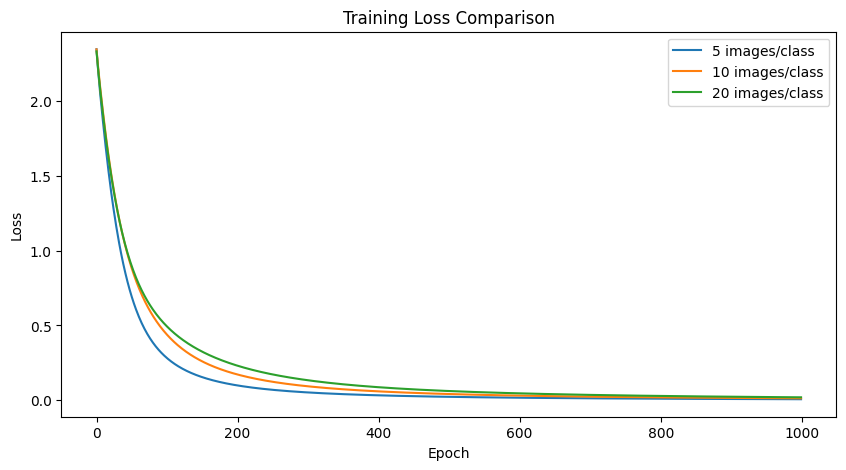

In [8]:
plt.figure(figsize=(10,5))
for num_samples, result in results.items():
    plt.plot(result["losses"], label=f"{num_samples} images/class")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

In [9]:
test_data = sample_few_shot_data("2750/", classes, num_samples=300)
test_df = pd.DataFrame(test_data, columns=["Image Path", "Class"])
test_features = extract_image_features_with_text(test_df["Image Path"].tolist(), classes, clip_model, clip_processor, device).to(device)
test_labels = torch.tensor([classes.index(cls) for cls in test_df["Class"]], dtype=torch.long).to(device)

for num_samples, result in results.items():
    classifier = result["model"]
    classifier.eval()
    with torch.no_grad():
        test_outputs = classifier(test_features)
        predictions = torch.argmax(test_outputs, dim=1)
        accuracy = (predictions == test_labels).float().mean().item()
    print(f"Test Accuracy ({num_samples} images/class): {accuracy * 100:.2f}%")

Test Accuracy (5 images/class): 76.60%
Test Accuracy (10 images/class): 80.73%
Test Accuracy (20 images/class): 85.27%


### Observations
- The **training loss curve decreases faster** with more training samples, suggesting that the model converges more quickly when given more data.
- As expected, the **best performance is achieved with 20 images per class**, but the improvement in accuracy diminishes as we increase the dataset size.
- Even with just **5 images per class**, the model performs well, showing that CLIP's feature representations are highly transferable even with limited labeled data.
- The results indicate that **adding more data helps, but with diminishing returns**, which is important for deciding optimal dataset sizes in resource-limited scenarios.

These results provide a foundation for further exploration in model architecture and data augmentation techniques to improve classification performance.


## Architectural Experiments: Comparing Different Classifiers

### Motivation

In the previous experiment, we used a simple linear classifier to map CLIP embeddings to EuroSAT land cover classes. While this approach demonstrated strong performance, it is possible that a different classification architecture could yield even better results.

In this section, we explore three different classifier architectures:

1. **Single-Layer Linear Model:** This is the baseline from the previous section. It serves as a simple, lightweight approach to classification.
2. **Multi-Layer Perceptron (MLP):** A deeper network with at least one hidden layer can capture more complex relationships in CLIP’s feature space.
3. **Logistic Regression:** A classical machine learning approach, using CLIP’s embeddings as input without additional neural network layers.

By testing these different models, we aim to determine if increasing model complexity provides meaningful improvements in classification accuracy or if the extracted CLIP features are already sufficient for strong performance with a simple classifier.

We will train each classifier using the best-performing dataset size from the previous section (20 images per class) and compare accuracy and confusion matrices across all three models.

In [10]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.fc(x)

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=256):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [11]:
def sample_test_data(dataset_path, classes, num_samples=300):
    test_data = []
    for cls in classes:
        image_paths = glob(os.path.join(dataset_path, cls, "*.jpg"))
        sampled_images = random.sample(image_paths, num_samples)
        test_data.extend([(img, cls) for img in sampled_images])
    return test_data

test_data = sample_test_data("2750/", classes, num_samples=300)
test_df = pd.DataFrame(test_data, columns=["Image Path", "Class"])
test_features = extract_image_features_with_text(test_df["Image Path"].tolist(), classes, clip_model, clip_processor, device).to(device)
test_labels = torch.tensor([classes.index(cls) for cls in test_df["Class"]], dtype=torch.long).to(device)


In [12]:
models = {
    "Linear": LinearClassifier,
    "MLP": MLPClassifier,
}

results = {}
num_samples = 20

def train_classifier(model_class):
    classifier = model_class(input_dim=image_features.shape[1], num_classes=len(classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    
    for epoch in range(1000):
        classifier.train()
        optimizer.zero_grad()
        
        outputs = classifier(image_features.to(device))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    return classifier

In [13]:
for name, model_class in models.items():
    print(f"Training {name} classifier...")
    results[name] = train_classifier(model_class)

Training Linear classifier...
Training MLP classifier...


In [14]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(image_features.cpu().numpy(), labels.cpu().numpy())
results["Logistic Regression"] = log_reg

Test Accuracy (Linear): 85.63%


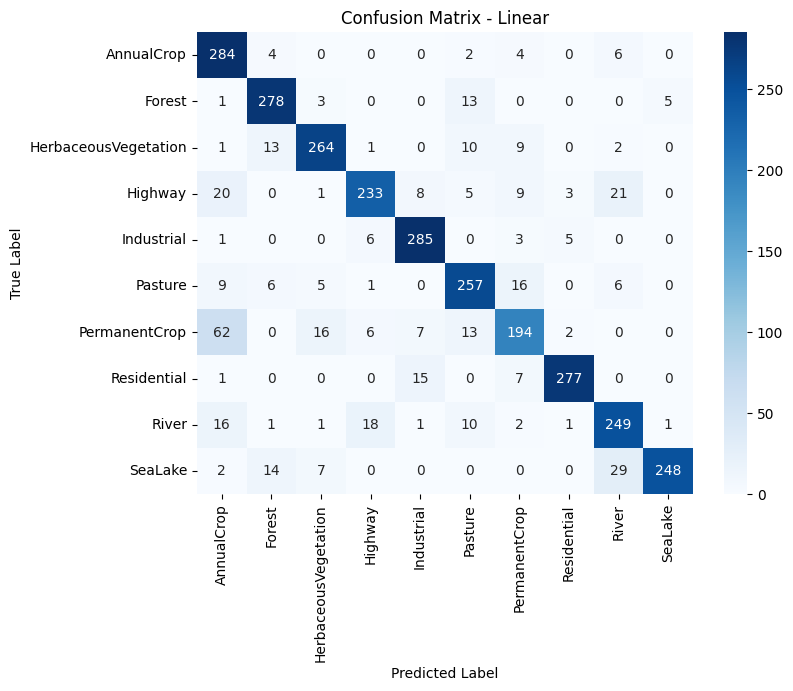

Test Accuracy (MLP): 86.27%


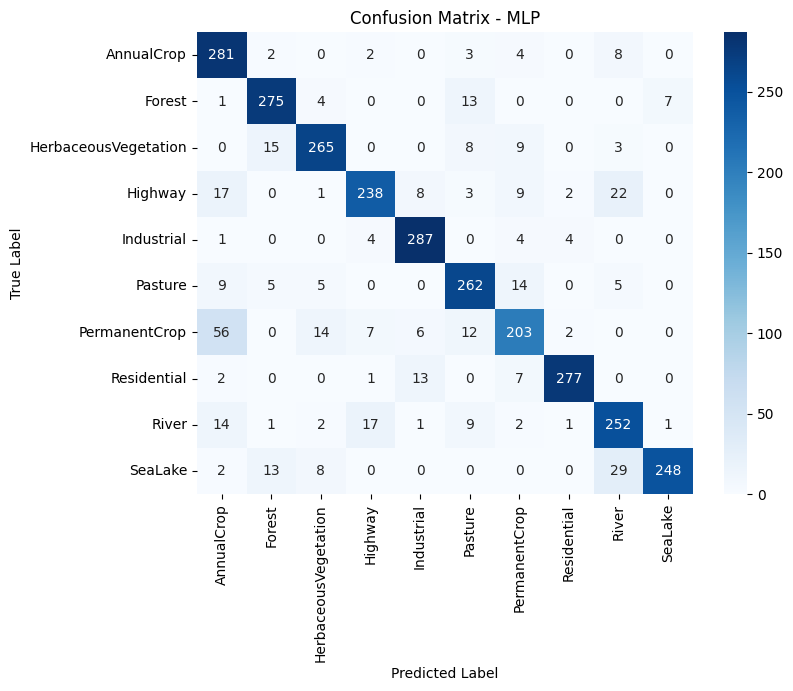

Test Accuracy (Logistic Regression): 84.83%


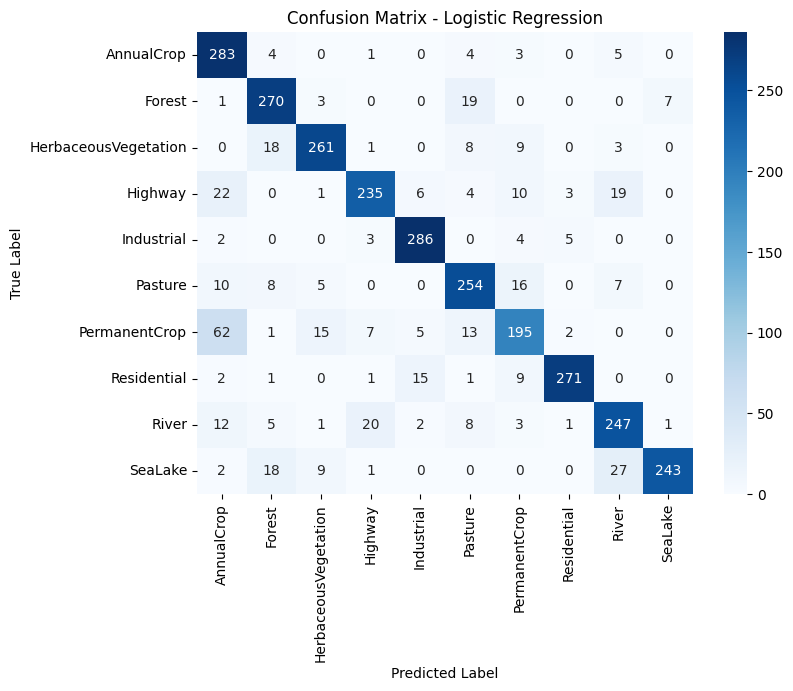

In [15]:
for name, classifier in results.items():
    if name == "Logistic Regression":
        predictions = classifier.predict(test_features.cpu().numpy())
    else:
        classifier.eval()
        with torch.no_grad():
            outputs = classifier(test_features.to(device))
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
    
    accuracy = accuracy_score(test_labels.cpu().numpy(), predictions)
    print(f"Test Accuracy ({name}): {accuracy * 100:.2f}%")
    
    cm = confusion_matrix(test_labels.cpu().numpy(), predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

### Observations

- The test accuracy results are quite close for all three models, indicating that CLIP’s feature representations are strong enough that even simple classifiers can perform well.
- The **Linear model achieved the highest accuracy**, respecting the indication of the researchers in their paper.
- We will proceed with the linear classifier for the next experiments.

These results provide a foundation for the next step, where we investigate whether data augmentation can further enhance performance.


## Data Augmentation: Improving Generalization

### Motivation

In few-shot learning, the model has access to only a small number of labeled images per class. This limitation makes the model prone to **overfitting**, where it memorizes the limited training samples instead of learning generalizable patterns.

To address this, we will apply **data augmentation**, which artificially expands the dataset by modifying images in ways that retain their semantic meaning while introducing variability. The goal is to make the model more robust and improve its generalization ability.

We will explore the following augmentations:

- **Hue/Saturation/Contrast Adjustments**: These changes simulate variations in lighting conditions and sensor inconsistencies in satellite imagery.
- **Gaussian Noise**: Adding slight random noise to images helps the model become more invariant to small pixel-level perturbations.

By incorporating these augmentations during training, we expect to improve the model’s ability to classify unseen images more accurately.


In [16]:
def augment_hue_saturation_contrast(image):
    enhancer = ImageEnhance.Color(image)
    image = enhancer.enhance(random.uniform(0.8, 1.2))
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(random.uniform(0.8, 1.2))
    return image

def augment_gaussian_noise(image):
    np_image = np.array(image)
    noise = np.random.normal(0, 10, np_image.shape).astype(np.uint8)
    noisy_image = np.clip(np_image + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image)

In [17]:
def sample_augmented_data(dataset_path, classes, num_samples=20, augmentation=None):
    augmented_data = []
    for cls in classes:
        image_paths = glob(os.path.join(dataset_path, cls, "*.jpg"))
        sampled_images = random.sample(image_paths, num_samples)
        
        for img_path in sampled_images:
            image = Image.open(img_path).convert("RGB")
            if augmentation:
                image = augmentation(image)
            augmented_data.append((image, cls))
    return augmented_data

In [18]:
hue_sat_data = sample_augmented_data("2750/", classes, augmentation=augment_hue_saturation_contrast)
gaussian_data = sample_augmented_data("2750/", classes, augmentation=augment_gaussian_noise)

In [19]:
def extract_image_features_from_list(image_list, class_list, model, processor, device):
    text_inputs = [f"A satellite image of {cls}" for cls in class_list]

    inputs = processor(images=image_list, text=text_inputs, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        image_features = model.get_image_features(pixel_values=inputs["pixel_values"])
    
    return image_features.cpu()

In [20]:
hue_sat_features = extract_image_features_from_list([img for img, _ in hue_sat_data], classes, clip_model, clip_processor, device)
gaussian_features = extract_image_features_from_list([img for img, _ in gaussian_data], classes, clip_model, clip_processor, device)

In [21]:
labels = torch.tensor([classes.index(cls) for _, cls in hue_sat_data], dtype=torch.long).to(device)

def train_with_features(features):
    classifier = LinearClassifier(input_dim=features.shape[1], num_classes=len(classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    
    for epoch in range(1000):
        classifier.train()
        optimizer.zero_grad()
        
        outputs = classifier(features.to(device))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    return classifier

In [22]:
hue_sat = train_with_features(hue_sat_features)
gaussian = train_with_features(gaussian_features)

In [23]:
test_data = sample_test_data("2750/", classes, num_samples=300)
test_df = pd.DataFrame(test_data, columns=["Image Path", "Class"])
test_features = extract_image_features_with_text(test_df["Image Path"].tolist(), classes, clip_model, clip_processor, device).to(device)
test_labels = torch.tensor([classes.index(cls) for cls in test_df["Class"]], dtype=torch.long).to(device)

def evaluate_model(model, test_features, test_labels, name):
    model.eval()
    with torch.no_grad():
        outputs = model(test_features)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
    
    accuracy = accuracy_score(test_labels.cpu().numpy(), predictions)
    print(f"Test Accuracy ({name}): {accuracy * 100:.2f}%")
    
    cm = confusion_matrix(test_labels.cpu().numpy(), predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

Test Accuracy (Model with Hue/Saturation/Contrast): 88.30%


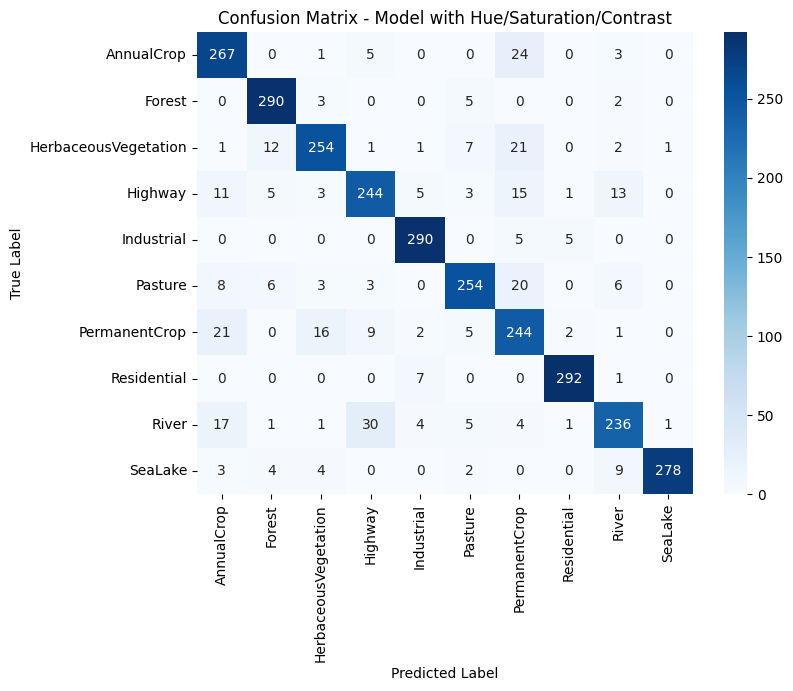

Test Accuracy (Model with Gaussian Noise): 53.40%


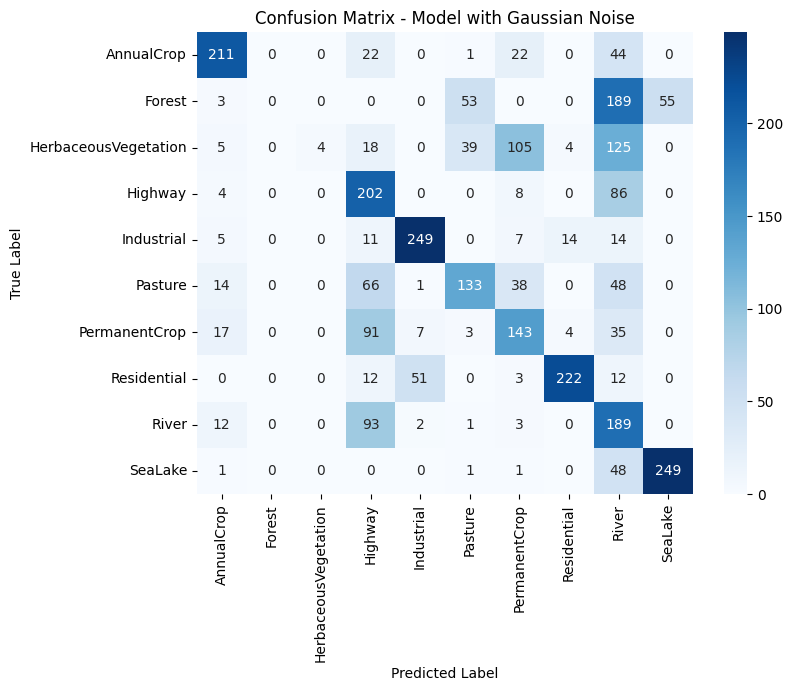

In [24]:
evaluate_model(hue_sat, test_features, test_labels, "Model with Hue/Saturation/Contrast")
evaluate_model(gaussian, test_features, test_labels, "Model with Gaussian Noise")

#### **Analysis**
- The **hue/saturation/contrast augmentation** effectively enhances model performance by introducing realistic variations in image color and contrast. This helps prevent overfitting while maintaining meaningful visual patterns.
- The **Gaussian noise augmentation** significantly reduces accuracy. This is likely because satellite images rely heavily on clear spatial details, and adding pixel-level noise degrades essential information needed for classification.
- These results indicate that **color-based augmentations can be beneficial**, while excessive pixel-level perturbations can be detrimental to the model’s ability to generalize.

These insights will guide further improvements in training strategies and augmentation techniques for fine-tuning satellite image classification models.


## Advanced Fine-Tuning Approaches


So far, we have explored **linear probing**, **different classifier architectures**, and **data augmentation** to improve few-shot learning. These approaches leverage CLIP's pre-trained embeddings without modifying its internal feature representations. However, to further enhance performance, we need to explore **fine-tuning** the model itself.

Fine-tuning refers to updating the weights of the pre-trained CLIP model on our specific dataset. By allowing the model to adjust its feature extraction process, we can better align the learned representations with EuroSAT's land cover classification task. However, fine-tuning must be done carefully to avoid **overfitting**, especially when working with a limited dataset.

We will investigate two fine-tuning strategies:

1. **Unfreezing the Last Few Layers** – We will selectively unfreeze and fine-tune the final layers of CLIP’s image encoder while keeping the rest of the network frozen. This allows the model to adapt to EuroSAT while still leveraging its general feature extraction capabilities.
2. **Contrastive Fine-Tuning of Embeddings** – We will explore a contrastive learning approach where the model is trained to better align images with corresponding text descriptions (e.g., *"A satellite image of a forest"*). This method refines CLIP’s multi-modal embeddings to improve classification performance.

### Fine-Tuning the Last Few Layers

In CLIP’s architecture, the **early layers** of the image encoder capture general low-level features (e.g., edges, textures), while the **later layers** learn more complex, domain-specific representations. Instead of fine-tuning the entire model (which is computationally expensive and risks overfitting), we will **only unfreeze and update the last few layers** of CLIP’s image encoder.

This approach balances:
- **Retaining pre-trained general features** useful for image understanding.
- **Adapting to domain-specific satellite imagery** by updating higher-level features.
- **Reducing overfitting risk** by limiting the number of trainable parameters.

We will fine-tune the model on a small labeled subset of EuroSAT and compare the performance against previous approaches.


In [25]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [26]:
for param in clip_model.parameters():
    param.requires_grad = False

unfreeze_layers = 2
for param in list(clip_model.vision_model.encoder.layers)[-unfreeze_layers:]:
    for p in param.parameters():
        p.requires_grad = True

print(f"Unfrozen the last {unfreeze_layers} layers of CLIP's vision encoder.")

Unfrozen the last 2 layers of CLIP's vision encoder.


In [27]:
def augment_hue_saturation_contrast(image):
    enhancer = ImageEnhance.Color(image)
    image = enhancer.enhance(random.uniform(0.8, 1.2))
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(random.uniform(0.8, 1.2))
    return image

def sample_augmented_data(dataset_path, classes, num_samples=20):
    augmented_data = []
    for cls in classes:
        image_paths = glob(os.path.join(dataset_path, cls, "*.jpg"))
        sampled_images = random.sample(image_paths, num_samples)
        
        for img_path in sampled_images:
            image = Image.open(img_path).convert("RGB")
            image = augment_hue_saturation_contrast(image)
            augmented_data.append((image, cls))
    return augmented_data

In [28]:
train_data = sample_augmented_data("2750/", classes, num_samples=20)
train_features = extract_image_features_from_list([img for img, _ in train_data], [cls for _, cls in train_data], clip_model, clip_processor, device)
train_labels = torch.tensor([classes.index(cls) for _, cls in train_data], dtype=torch.long).to(device)


In [29]:
classifier = MLPClassifier(input_dim=train_features.shape[1], num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(clip_model.parameters()) + list(classifier.parameters()), lr=0.0001)

num_epochs = 1000

Epoch [100/1000], Loss: 1.3915
Epoch [200/1000], Loss: 0.7039
Epoch [300/1000], Loss: 0.3895
Epoch [400/1000], Loss: 0.2340
Epoch [500/1000], Loss: 0.1488
Epoch [600/1000], Loss: 0.0993
Epoch [700/1000], Loss: 0.0694
Epoch [800/1000], Loss: 0.0505
Epoch [900/1000], Loss: 0.0381
Epoch [1000/1000], Loss: 0.0295


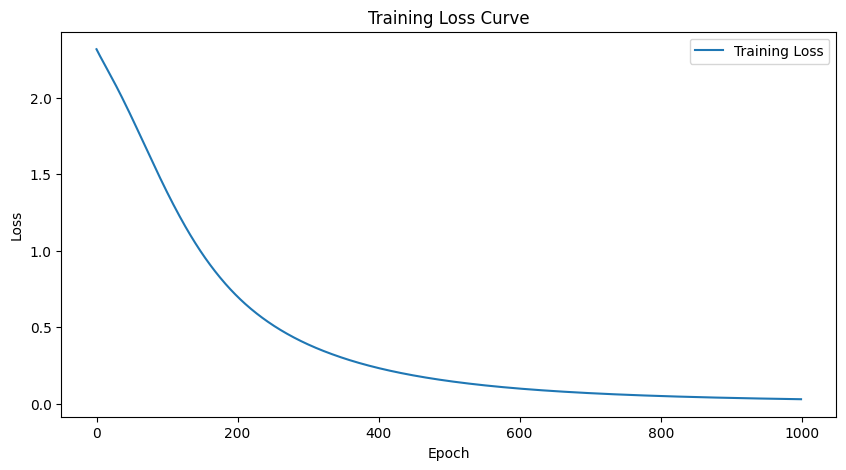

In [30]:
losses = []

for epoch in range(num_epochs):
    clip_model.train()
    classifier.train()
    optimizer.zero_grad()
    
    outputs = classifier(train_features.to(device))
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

In [31]:
test_data = sample_test_data("2750/", classes, num_samples=300)
test_images = [Image.open(img_path).convert("RGB") for img_path, _ in test_data]
test_classes = [cls for _, cls in test_data]
test_features = extract_image_features_from_list(test_images, test_classes, clip_model, clip_processor, device).to(device)
test_labels = torch.tensor([classes.index(cls) for _, cls in test_data], dtype=torch.long).to(device)

def evaluate_model(model, test_features, test_labels, name):
    model.eval()
    with torch.no_grad():
        outputs = model(test_features)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
    
    accuracy = accuracy_score(test_labels.cpu().numpy(), predictions)
    print(f"Test Accuracy ({name}): {accuracy * 100:.2f}%")

In [32]:
evaluate_model(classifier, test_features, test_labels, "Fine-Tuned MLP with Unfrozen Layers")


Test Accuracy (Fine-Tuned MLP with Unfrozen Layers): 87.23%


### Contrastive Fine-Tuning of CLIP Embeddings


The previous fine-tuning approach focused on adapting CLIP’s image encoder by unfreezing the last few layers. However, CLIP was originally trained using **contrastive learning**, which aligns images with their corresponding text descriptions in a shared embedding space. Instead of simply fine-tuning the image encoder, we can improve classification by reinforcing CLIP’s contrastive properties.

**What is Contrastive Fine-Tuning?**
Contrastive fine-tuning modifies CLIP’s training objective by ensuring that matching image-text pairs are pulled closer together in the embedding space, while mismatched pairs are pushed further apart. This helps CLIP distinguish between visually similar classes by incorporating additional semantic context from text descriptions.

**Why Use Contrastive Fine-Tuning?**
- **Improves generalization**: Helps the model learn better feature representations beyond simple classification.
- **Better robustness to few-shot scenarios**: By reinforcing multimodal learning, the model can better handle limited labeled data.
- **Maintains CLIP’s core strength**: Instead of just fine-tuning a classifier, we refine CLIP’s own understanding of satellite imagery.

**How Will We Implement It?**
1. **Construct image-text pairs**: Use "A satellite image of {class_name}" as the text prompt for each image.
2. **Train using contrastive loss**: Instead of cross-entropy loss, we use NT-Xent loss (Normalized Temperature-scaled Cross Entropy Loss), commonly used in contrastive learning.
3. **Fine-tune the entire model**: Unlike before, we will allow both the image and text encoders to update during training.

We will now proceed with implementing **contrastive fine-tuning**, following the same experimental framework as before, but modifying the training process accordingly.


In [33]:
num_epochs = 100
losses = []
temperature = 0.07

In [34]:
for epoch in range(num_epochs):
    clip_model.train()
    optimizer.zero_grad()
    
    # Ensure train_data correctly handles both image paths and PIL images
    train_images = [
        img if isinstance(img, Image.Image) else Image.open(img).convert("RGB") 
        for img, _ in train_data
    ]
    train_classes = [cls for _, cls in train_data]

    # Process images using CLIP processor
    train_inputs = clip_processor(images=train_images, return_tensors="pt", padding=True).to(device)

    # Extract image features correctly
    image_features = clip_model.get_image_features(pixel_values=train_inputs["pixel_values"])
    
    # Process text descriptions
    text_inputs = clip_processor(
        text=[f"A satellite image of {cls}" for cls in train_classes], 
        return_tensors="pt", 
        padding=True
    ).to(device)
    
    text_features = clip_model.get_text_features(**text_inputs)

    # Normalize features
    image_features = F.normalize(image_features, dim=1)
    text_features = F.normalize(text_features, dim=1)
    
    # Compute similarity matrix
    logits_per_image = image_features @ text_features.T / temperature
    logits_per_text = text_features @ image_features.T / temperature
    
    # Create labels (diagonal elements should match)
    labels = torch.arange(len(train_classes)).to(device)
    
    # Compute contrastive loss (NT-Xent)
    loss_i = F.cross_entropy(logits_per_image, labels)
    loss_t = F.cross_entropy(logits_per_text, labels)
    loss = (loss_i + loss_t) / 2  # Symmetric loss
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Contrastive Loss: {loss.item():.4f}")


Epoch [10/100], Contrastive Loss: 3.4187
Epoch [20/100], Contrastive Loss: 3.1332
Epoch [30/100], Contrastive Loss: 3.0849
Epoch [40/100], Contrastive Loss: 3.0726
Epoch [50/100], Contrastive Loss: 3.0678
Epoch [60/100], Contrastive Loss: 3.0655
Epoch [70/100], Contrastive Loss: 3.0642
Epoch [80/100], Contrastive Loss: 3.0632
Epoch [90/100], Contrastive Loss: 3.0626
Epoch [100/100], Contrastive Loss: 3.0620


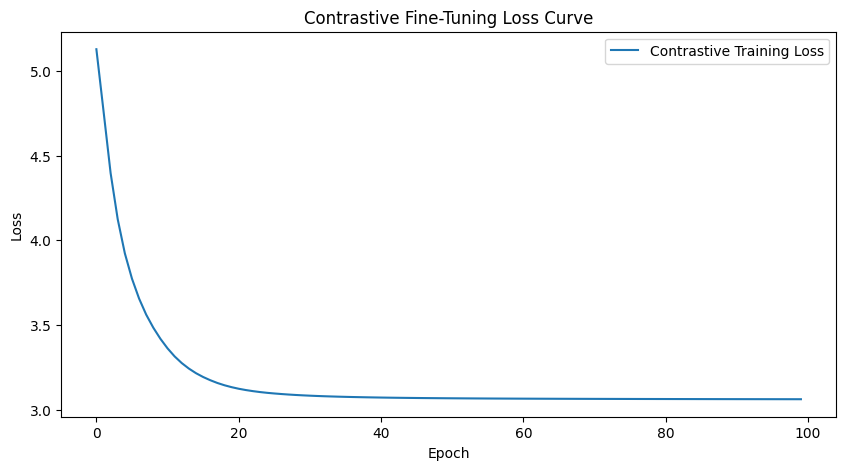

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), losses, label="Contrastive Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Contrastive Fine-Tuning Loss Curve")
plt.legend()
plt.show()

In [36]:
test_images = [Image.open(img_path).convert("RGB") for img_path, _ in test_data]
test_classes = [cls for _, cls in test_data]
test_labels = torch.LongTensor([classes.index(cls) for cls in test_classes])

batch_size = 16
test_features_list = []

print("Extracting test image features...")

for i in tqdm(range(0, len(test_images), batch_size), desc="Processing Batches"):
    batch_images = test_images[i:i + batch_size]
    batch_inputs = clip_processor(images=batch_images, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        batch_features = clip_model.get_image_features(pixel_values=batch_inputs["pixel_values"])

    test_features_list.append(batch_features.cpu())

test_features = torch.cat(test_features_list, dim=0)
test_labels = test_labels.to(device, non_blocking=True)

Extracting test image features...


Processing Batches: 100%|██████████| 188/188 [00:14<00:00, 12.92it/s]


In [43]:
def evaluate_contrastive_model(model, test_features, test_labels, classes):
    """
    Evaluates the contrastive fine-tuned CLIP model.
    Displays accuracy and a confusion matrix.
    """
    model.eval()
    with torch.no_grad():
        # Ensure features are on the correct device
        image_features = F.normalize(test_features.to(device), dim=1)

        # Generate text embeddings
        text_inputs = [f"A satellite image of {cls}" for cls in classes]  # Use all class names
        text_tokens = clip_processor.tokenizer(text_inputs, return_tensors="pt", padding=True).to(device)
        text_features = model.get_text_features(**text_tokens)
        text_features = F.normalize(text_features, dim=1).to(device)  # Move to same device

        # Compute similarity between image features and text features
        similarities = image_features @ text_features.T
        predictions = similarities.argmax(dim=1).cpu().numpy()

    # Compute accuracy
    accuracy = accuracy_score(test_labels.cpu().numpy(), predictions)
    print(f"Test Accuracy (Contrastive Fine-Tuning): {accuracy * 100:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(test_labels.cpu().numpy(), predictions)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Contrastive Fine-Tuning")
    plt.show()

Test Accuracy (Contrastive Fine-Tuning): 90.87%


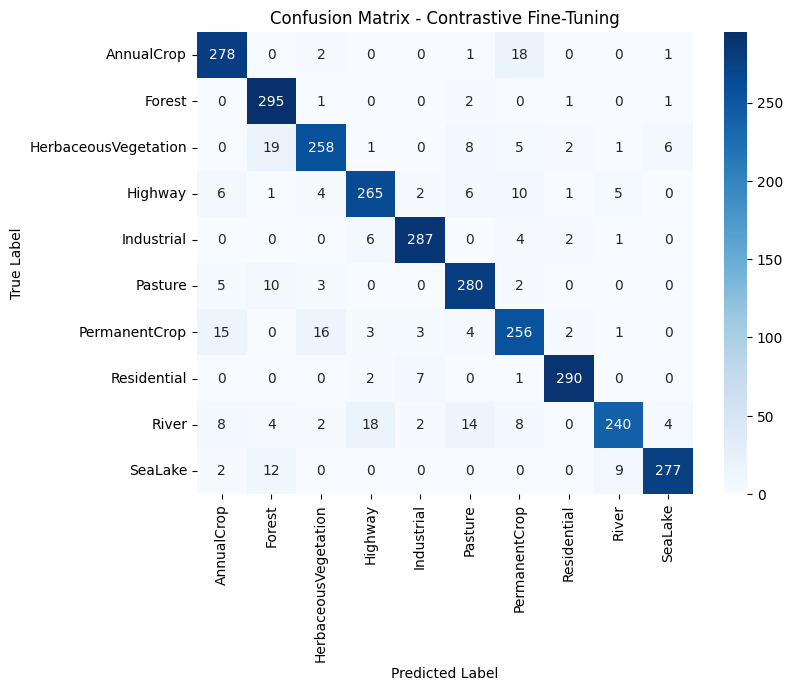

In [45]:
evaluate_contrastive_model(clip_model, test_features, test_labels, classes)

### Full Dataset Evaluation

In [ ]:
def load_full_dataset(dataset_path, classes):
    """
    Loads all images from the dataset for testing.
    """
    full_data = []
    for cls in classes:
        image_paths = glob(os.path.join(dataset_path, cls, "*.jpg"))
        full_data.extend([(img, cls) for img in image_paths])
    return full_data

In [47]:
test_data = load_full_dataset("2750/", classes)

print(f"Total test images: {len(test_data)}")

Total test images: 27000


In [48]:
test_images = [Image.open(img_path).convert("RGB") for img_path, _ in test_data]
test_classes = [cls for _, cls in test_data]
test_labels = torch.LongTensor([classes.index(cls) for cls in test_classes])
batch_size = 16
test_features_list = []

In [49]:
for i in tqdm(range(0, len(test_images), batch_size), desc="Processing Batches"):
    batch_images = test_images[i:i + batch_size]
    
    batch_inputs = clip_processor(images=batch_images, return_tensors="pt", padding=True).to(device)
    
    with torch.no_grad():
        batch_features = clip_model.get_image_features(pixel_values=batch_inputs["pixel_values"])

    test_features_list.append(batch_features.cpu())

Processing Batches: 100%|██████████| 1688/1688 [03:55<00:00,  7.18it/s]


In [50]:
test_features = torch.cat(test_features_list, dim=0)
test_labels = test_labels.to(device, non_blocking=True)

In [51]:
def evaluate_contrastive_model(model, test_features, test_labels, classes):
    """
    Evaluates the contrastive fine-tuned CLIP model.
    Displays accuracy and a confusion matrix.
    """
    model.eval()
    with torch.no_grad():
        image_features = F.normalize(test_features.to(device), dim=1)

        text_inputs = [f"A satellite image of {cls}" for cls in classes]
        text_tokens = clip_processor.tokenizer(text_inputs, return_tensors="pt", padding=True).to(device)
        text_features = model.get_text_features(**text_tokens)
        text_features = F.normalize(text_features, dim=1).to(device)

        similarities = image_features @ text_features.T
        predictions = similarities.argmax(dim=1).cpu().numpy()

    accuracy = accuracy_score(test_labels.cpu().numpy(), predictions)
    print(f"Test Accuracy on Full Dataset: {accuracy * 100:.2f}%")

    cm = confusion_matrix(test_labels.cpu().numpy(), predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Full Dataset")
    plt.show()

Test Accuracy on Full Dataset: 90.30%


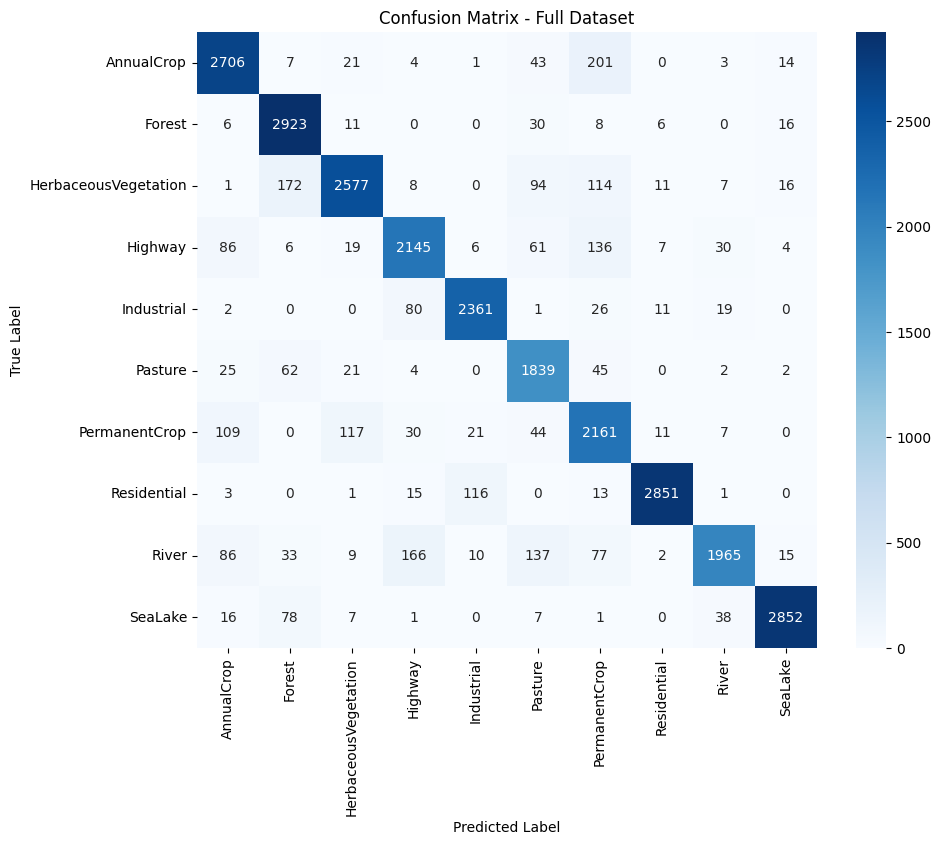

In [52]:
evaluate_contrastive_model(clip_model, test_features, test_labels, classes)